## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from scipy.stats import spearmanr
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import AlbertTokenizer
import transformers

from text_data import TextDataset5 as TextDataset
from albert import CustomAlbert
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed
from utils.torch import to_cpu

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 12 s, sys: 104 ms, total: 12.1 s
Wall time: 12.4 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2

## Training model

In [8]:
device = 'cuda'
pretrained_model = 'siamese_albert_1'
head_model_name = 'siamese_albert_1_head'
model_name = 'siamese_albert_1_comb'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [9]:
def load_model(checkpoint_file, model):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    
def get_pretrained_model(fold_id):
    checkpoint_file = f'{checkpoint_dir}{pretrained_model}_fold_{fold_id+1}_best.pth'
    model = CustomAlbert(256, cat_features_train.shape[1])
    load_model(checkpoint_file, model)
    return model

def load_head(model, fold_id):
    checkpoint_file = f'{checkpoint_dir}{head_model_name}_fold_{fold_id+1}_best.pth'
    load_model(checkpoint_file, model.head)

def save_model(model):
    checkpoint_file = f'{checkpoint_dir}{model_name}_fold_{fold_id+1}_best.pth'
    torch.save({'model_state_dict': model.state_dict()}, checkpoint_file)
    
def load_saved_model(model):
    checkpoint_file = f'{checkpoint_dir}{model_name}_fold_{fold_id+1}_best.pth'
    load_model(checkpoint_file, model)

In [10]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    
    model = get_pretrained_model(fold_id)
    load_head(model, fold_id)
    save_model(model)
    load_saved_model(model)
    
    oofs[valid_index] = infer(model, valid_loader, None, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    del model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


Fold 1 started at Thu Feb  6 21:40:00 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
There is currently an upstream reproducibility issue with ALBERT v2 mod


Averaged Val. score: 0.41674470840310823
Fold 2 started at Thu Feb  6 21:40:27 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Averaged Val. score: 0.4269527738895812
Fold 3 started at Thu Feb  6 21:40:52 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Averaged Val. score: 0.408231991975439
Fold 4 started at Thu Feb  6 21:41:17 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Averaged Val. score: 0.4038711577489126
Fold 5 started at Thu Feb  6 21:41:42 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Averaged Val. score: 0.4005122318438642
Fold 6 started at Thu Feb  6 21:42:07 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Averaged Val. score: 0.39638985836634394
Fold 7 started at Thu Feb  6 21:42:32 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Averaged Val. score: 0.4156167387280483
Fold 8 started at Thu Feb  6 21:42:58 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Averaged Val. score: 0.42004157988172736
Fold 9 started at Thu Feb  6 21:43:23 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Averaged Val. score: 0.4136763094379314
Fold 10 started at Thu Feb  6 21:43:48 2020


There is currently an upstream reproducibility issue with ALBERT v2 models. Please see https://github.com/google-research/google-research/issues/119 for more information.



Averaged Val. score: 0.4204006695362236
OOF score: 0.41300781155691596


In [11]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 8 0.47231165705176625
5 4 0.4588563696347066
9 64 0.11902041556713282
11 8 0.7561803680315404
12 4 0.4934870423601095
13 32 0.2021768461753178
14 8 0.6078719826196841
15 4 0.5744369621253741
16 16 0.7828613099457135
19 16 0.24525016795977644


In [12]:
np.array(opt_ds), np.array(opt_indices)

(array([ 8,  4, 64,  8,  4, 32,  8,  4, 16, 16]),
 array([ 2,  5,  9, 11, 12, 13, 14, 15, 16, 19]))

In [13]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [14]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.413008
CV unique rows,0.378925
CV ignoring hard targets,0.436447
CV unique rows ignoring hard targets,0.399252
CV w rounding,0.441115
CV unique rows w rounding,0.419050
CV ignoring hard targets w rounding,0.459613
CV unique rows ignoring hard targets w rounding,0.427772


In [15]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.416960
CV unique rows,0.383035
CV ignoring hard targets,0.436447
CV unique rows ignoring hard targets,0.399252
CV w rounding,0.441115
CV unique rows w rounding,0.419050
CV ignoring hard targets w rounding,0.459613
CV unique rows ignoring hard targets w rounding,0.427772


In [16]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [17]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.826592,0.840113,0.225524,0.496306,0.557586,0.357990,0.671529,0.603076,0.152584,0.001845,0.661260,0.112065,0.163199,0.054087,0.004878,0.073453,0.127474,0.132488,0.679780,0.000189,0.887534,0.864170,0.546606,0.938327,0.913482,0.669935,0.082470,0.098609,0.859169,0.787350
1,0.840513,0.717097,0.114959,0.642396,0.926172,0.680830,0.553107,0.670566,0.250027,0.001595,0.281042,0.105070,0.855620,0.005960,0.702855,0.061423,0.010687,0.019594,0.354106,0.011934,0.784642,0.566572,0.316222,0.693775,0.772133,0.346388,0.007025,0.017972,0.490801,0.718345
2,0.514406,0.169816,0.008477,0.702178,0.749296,0.829472,0.423101,0.254015,0.127347,0.003197,0.385368,0.308368,0.015299,0.007040,0.001119,0.176181,0.686632,0.299534,0.168155,0.000071,0.411862,0.886899,0.605841,0.935627,0.928945,0.713579,0.655846,0.389298,0.509763,0.707071
3,0.834574,0.758913,0.083484,0.854572,0.744422,0.850374,0.562583,0.628842,0.243243,0.001029,0.311352,0.960011,0.030704,0.028688,0.030847,0.016514,0.053145,0.165123,0.399253,0.005253,0.817275,0.833804,0.750938,0.851390,0.925516,0.784078,0.131130,0.246656,0.718865,0.720414
4,0.798984,0.781527,0.002609,0.690579,0.821034,0.906630,0.487427,0.464812,0.400670,0.000125,0.318296,0.696765,0.001318,0.000585,0.000752,0.004915,0.886193,0.286999,0.085276,0.000009,0.796249,0.766624,0.402253,0.831917,0.926793,0.633970,0.926338,0.166645,0.014816,0.524730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.874027,0.492799,0.206331,0.846007,0.651091,0.656825,0.702775,0.741284,0.392512,0.003958,0.452119,0.918934,0.091871,0.122587,0.022574,0.154272,0.035813,0.097513,0.429450,0.004602,0.691760,0.925187,0.774518,0.952615,0.962254,0.808510,0.070711,0.107132,0.886020,0.763157
6075,0.804373,0.222431,0.106790,0.527938,0.402159,0.447493,0.651704,0.662189,0.113715,0.007719,0.798347,0.017283,0.020990,0.008347,0.000900,0.021478,0.825831,0.433262,0.175520,0.000135,0.581822,0.855279,0.627374,0.939888,0.937234,0.675699,0.799586,0.404970,0.305224,0.825752
6076,0.531389,0.372871,0.001410,0.721606,0.664986,0.925206,0.387333,0.233770,0.150572,0.000762,0.501888,0.673549,0.000204,0.000652,0.000140,0.000669,0.911319,0.363327,0.128508,0.000004,0.355663,0.690673,0.411553,0.895777,0.884472,0.499085,0.712098,0.191390,0.691642,0.610411
6077,0.754114,0.351797,0.728689,0.220312,0.214588,0.095490,0.667461,0.787521,0.899657,0.004579,0.931162,0.646979,0.250359,0.158027,0.049037,0.078453,0.050186,0.316725,0.705558,0.000863,0.694662,0.726621,0.556617,0.841901,0.843556,0.479376,0.023882,0.103076,0.803523,0.764355


In [18]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.383865
question_body_critical                   0.658675
question_conversational                  0.410947
question_expect_short_answer             0.299002
question_fact_seeking                    0.353220
question_has_commonly_accepted_answer    0.419150
question_interestingness_others          0.354773
question_interestingness_self            0.502521
question_multi_intent                    0.583816
question_not_really_a_question           0.102141
question_opinion_seeking                 0.468494
question_type_choice                     0.741528
question_type_compare                    0.360517
question_type_consequence                0.171786
question_type_definition                 0.363872
question_type_entity                     0.451590
question_type_instructions               0.780146
question_type_procedure                  0.358359
question_type_reason_explanation         0.668246
question_type_spelling                   0.067568


In [19]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.067568,3.0
question_not_really_a_question,0.102141,5.0
question_type_consequence,0.171786,5.0
answer_relevance,0.171802,9.0
answer_plausible,0.174786,9.0
answer_well_written,0.214878,9.0
answer_helpful,0.273075,9.0
question_expect_short_answer,0.299002,5.0
answer_type_procedure,0.301744,5.0
question_fact_seeking,0.353220,5.0


In [20]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'question_type_consequence', 'answer_relevance', 'answer_plausible'],
      dtype='object')

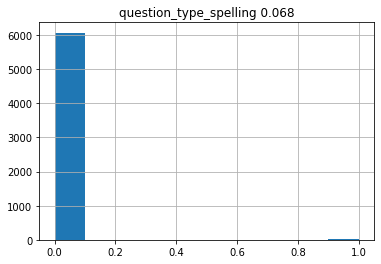

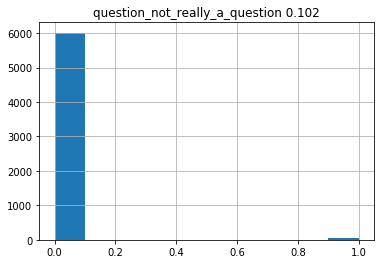

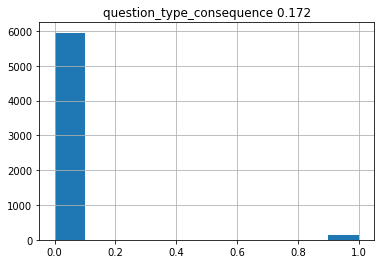

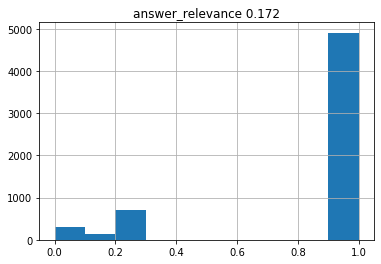

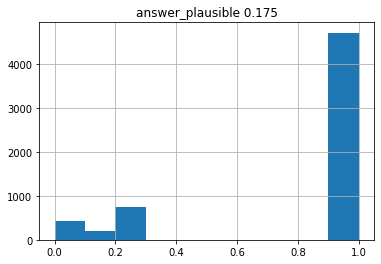

In [21]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


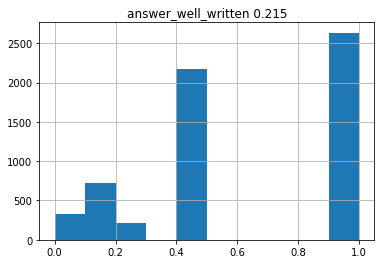

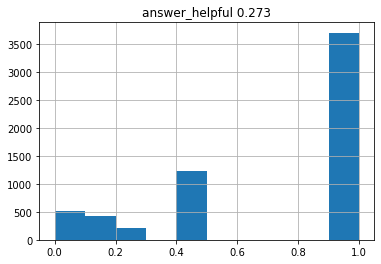

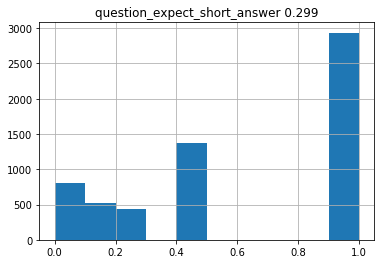

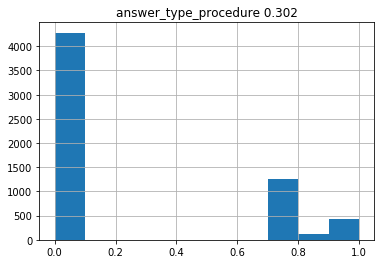

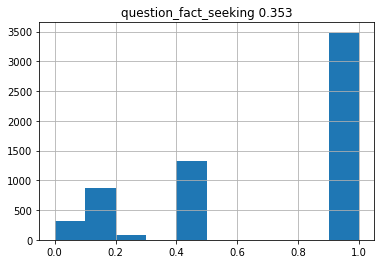

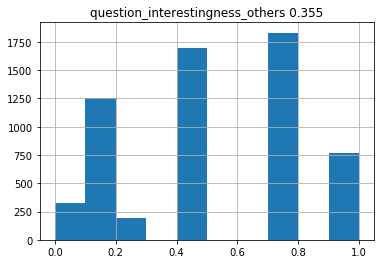

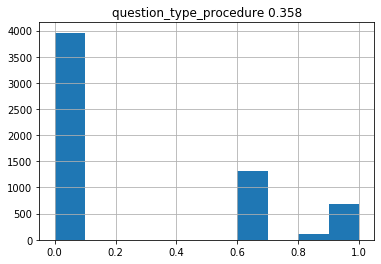

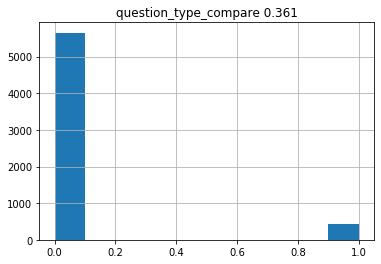

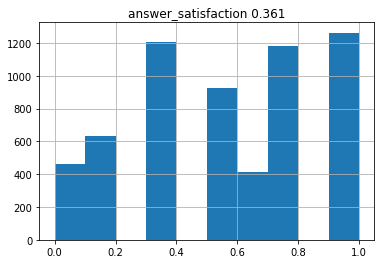

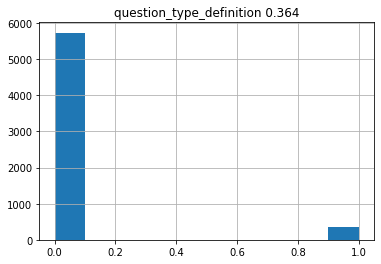

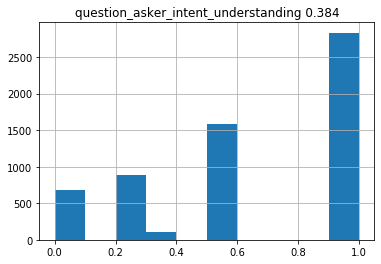

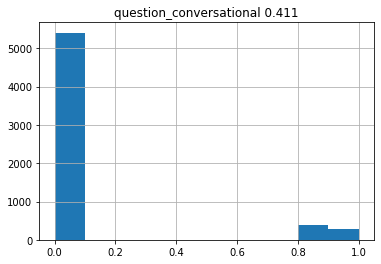

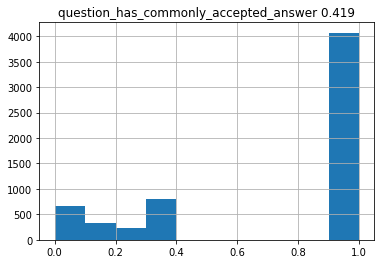

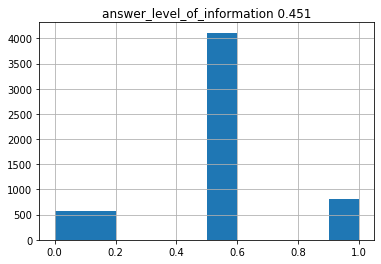

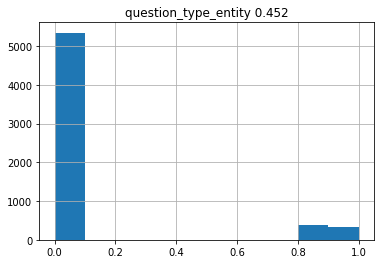

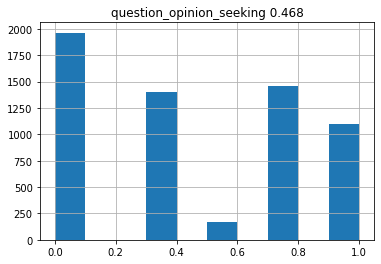

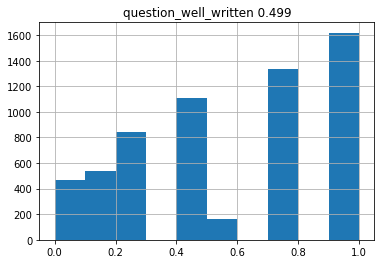

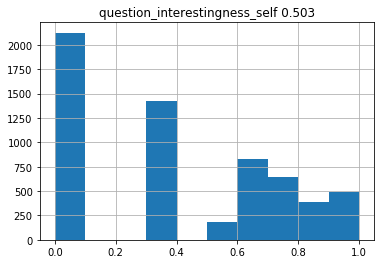

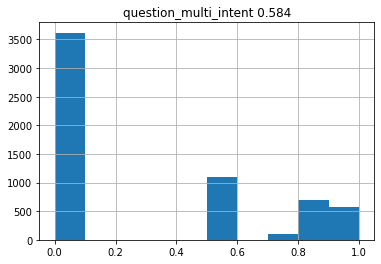

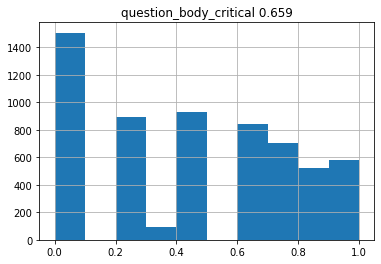

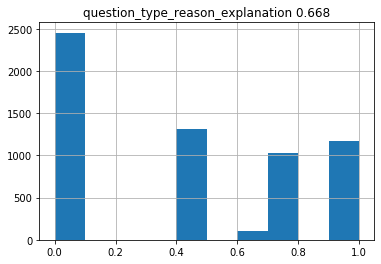

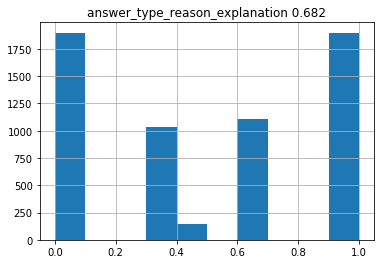

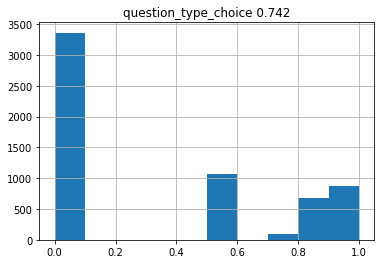

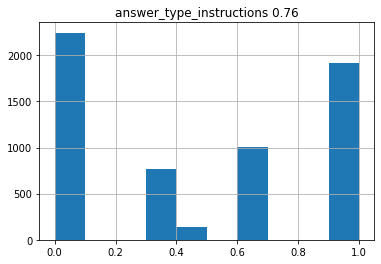

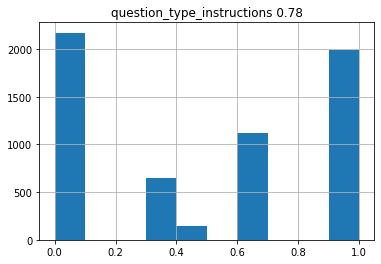

In [22]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')